In [2473]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import time
import datetime
from queue import Queue
from collections import deque
from scipy.stats import norm
from itertools import accumulate

%matplotlib inline

In [2474]:
plt.style.use('fivethirtyeight')

# Requirements

The 4 Coronavirus Datasets
- https://www.kaggle.com/sudalairajkumar/datasets
- https://www.kaggle.com/kimjihoo/datasets

In [2475]:
base_dir = '/Users/morgan/Code/Data/Covid19'
general_path = os.path.join(base_dir,'novel-corona-virus-2019-dataset')
korea_path = os.path.join(base_dir,'coronavirusdataset')
USA_path = os.path.join(base_dir,'covid19-in-usa')
Italy_path = os.path.join(base_dir,'covid19-in-italy')

In [2476]:
korea_timeline = os.path.join(korea_path,'Time.csv')
general_timeline = os.path.join(general_path,'time_series_covid_19_confirmed.csv')
USA_1 = os.path.join(USA_path,'us_covid19_daily.csv')
USA_2 = os.path.join(USA_path,'us_states_covid19_daily.csv')
italy_file = os.path.join(Italy_path,'covid19_italy_region.csv')
italy_file2 = os.path.join(Italy_path,'covid19_italy_province.csv')
US_states_testing_file = os.path.join(base_dir,'states.csv')
US_testing_file = os.path.join(base_dir,'time_series.csv')

In [2477]:
korea_df = pd.read_csv(korea_timeline)
general_df = pd.read_csv(general_timeline)
USA_1df = pd.read_csv(USA_1)
USA_2df = pd.read_csv(USA_2)
italy_df = pd.read_csv(italy_file)
italy_df2 = pd.read_csv(italy_file2)
USA_state_testing_df = pd.read_csv(US_states_testing_file)
USA_testing_df = pd.read_csv(US_testing_file)

In [2478]:
USA_2df.tail()

,date,state,positive,negative,pending,hospitalized,death,total,dateChecked
920,20200304,OR,3.0,29.0,18.0,NaN,NaN,50,2020-03-04T21:00:00Z
921,20200304,SC,0.0,5.0,0.0,NaN,NaN,5,2020-03-04T21:00:00Z
922,20200304,TX,1.0,NaN,NaN,NaN,NaN,1,2020-03-04T21:00:00Z
923,20200304,WA,39.0,NaN,NaN,NaN,NaN,39,2020-03-04T21:00:00Z
924,20200304,WI,1.0,19.0,6.0,NaN,NaN,26,2020-03-04T21:00:00Z


In [2479]:
italy_df.tail()

,SNo,Date,Country,RegionCode,RegionName,Latitude,Longitude,HospitalizedPatients,IntensiveCarePatients,TotalHospitalizedPatients,HomeConfinement,CurrentPositiveCases,NewPositiveCases,Recovered,Deaths,TotalPositiveCases,TestsPerformed
583,583,2020-03-22 17:00:00,ITA,9,Toscana,43.769231,11.255889,706,215,921,1223,2144,239,42,91,2277,13264
584,584,2020-03-22 17:00:00,ITA,4,P.A. Trento,46.068935,11.121231,235,46,281,604,885,165,34,35,954,3050
585,585,2020-03-22 17:00:00,ITA,10,Umbria,43.106758,12.388247,97,35,132,368,500,53,5,16,521,3135
586,586,2020-03-22 17:00:00,ITA,2,Valle d'Aosta,45.737503,7.320149,63,21,84,270,354,50,1,9,364,950
587,587,2020-03-22 17:00:00,ITA,5,Veneto,45.434905,12.338452,1113,255,1368,3276,4644,430,309,169,5122,57671


# Glossary

- R0. R naught. How many people does one infected person infect on average

# Hypothesis

- Check doubling sequence with R not based on initial data. See how that matches up with reality
- Perhaps as % of population
- Match up increase rates with quarantine measures?

Essentially what it takes is lockdown. So then the question is, when will the USA go into lockdown completely?

- What metrics do other countries use to determine lockdowns? % of population, number of free hospital beds vs hospitalized covid patients, etc.
- When will the US reach those metrics?
- How effective is the soft lockdown? and how if so is it enough as to avoid lockdown?

Italy may be the best comparison
- 60M people
- Quarantined on March 9 (with additional restrictions added later)

It doesn't matter in terms of the exponential whether you consider each state separately or all together. Except in terms of very specific things like distribution of age, or other slight factors. It does however matter a lot in terms of the hospital beds. The hospital beds are being stressed locally. So if we model the exponential globally, but account for the hospital beds and % split of infected locally, that should be a pretty good indication.

Hospital Beds in the USA https://www.kff.org/other/state-indicator/beds-by-ownership/?currentTimeframe=0&sortModel=%7B%22colId%22:%22Location%22,%22sort%22:%22asc%22%7D

## New Goal

Modeling the S curve as the R0 decreases due to preventative measures and social distancing. With this view, it appears that any of the worst case scenarios are of 0% and its very unlikely to even reach a million cases initially. If the curve is sufficently flattened, it may become another one of the flu strains that roams the world. But we won't be looking at the severe strain that some had projected.

## USA

from https://www.nytimes.com/interactive/2020/03/17/upshot/hospital-bed-shortages-coronavirus.html

- Number of Hospitals 6,146
- Number of admissions 36,353,946
- total hospital beds 738,000 
- total unoccupied beds 265,000
- total ICU beds 85,000
- total unoccupied ICU beds 32,000 - 45k

## Italy

- Number of hospital beds per 1k people 3.2
- Number of people 60.48M
- Number of hospital beds 18.9k
- 12.5 critical care beds per 100k people https://www.ft.com/content/34f25036-62f4-11ea-a6cd-df28cc3c6a68
- 7560 ICU beds

#### Lockdown stats

- Declared lockdown march 9 2020
- 9172 cases
- 1797 daily cases 
- 7985 currently infected 
- 463 deaths 
- 97 daily deaths 
- 638 or 8% Serious or critical

USA has 5.4x the population of Italy. If we scale these numbers to USA

- 45860 cases
- 9703.8 daily cases 
- 43119 currently infected
- 2500.2 deaths
- 523.8 daily deaths
- 3445.2 Serious or critical

USA currently

- 9259 total cases
- 9003 active cases
- 2848 daily cases
- 155 total deaths
- 41 daily deaths
- 108 recovered

# USA State specifics

### New York

- ICU Beds 3k
- 80% are filled
- Ordering an additional 18,600 - 37,200 beds
- has 53k normal beds, wants 110k

### Washington

- 7.54M
- 1.7 per 1000k people
- 12.818k hospital beds

### California

- Pop 39.56M
- 7274 ICU beds
- 58% occupied
- 4219 Unoccupied ICU beds
- 1.8 per 1000k people
- 71.208k hospital beds

## C19 Characteristics

- R0 of 2.5
- Average of 5 days before symptoms
- Hospital recovery time of 2.5 weeks
- Average number of hospitalizations?

# Utils

In [2480]:
def plot_totals(cases,deaths=None):
    epochs = range(1,len(cases)+1)
    plt.plot(epochs,cases,'g',label="Confirmed Cases")
    if deaths:
        plt.plot(epochs,deaths,'m',label="Deaths")
    plt.title('Covid19')
    plt.xlabel('Days')
    plt.ylabel('Cases')
    plt.legend()
    plt.show()

#     plt.clf()
#     acc = history.history['acc']
#     val_acc = history.history['val_acc']

#     plt.plot(epochs,acc,'bo',label='Training acc')
#     plt.plot(epochs,val_acc,'b',label='Validation acc')
#     plt.title('Training and validation accuracy')
#     plt.xlabel('Epochs')
#     plt.ylabel('Accuracy')
#     plt.legend()

#     plt.show()

def return_polyfit(x,y,degree):
    import numpy.polynomial.polynomial as poly
    coefs = poly.polyfit(x, y, degree)
    ffit = poly.polyval(x, coefs)
    return ffit,coefs

def parse_date(date_str):
    return datetime.datetime.strptime(date_str,'%m/%d/%y')

def determine_R0(points):
    """
    Requires two data points (x,y)
    first X is assumed to be 0
    Ae^rx = y
    """
    x1,y1 = points[0]
    x2,y2 = points[1]
    # 1st point
#     a = y1
#     # 2nd point
#     r = np.log(y2 / a) / x2
#     print(r)
#     print(R0)
    # r = (y2/y1)^(1/x2-x1)
#     r = np.log(y2/y1) / x2-x1
#     R0 = np.exp(r)
    R0 = np.power((y2/y1),(1/(x2-x1)))
    A = y1 / np.power(R0,x1)
    return R0,A

def graph_expo(x,points):
    x1,y1 = points[0]
    x2,y2 = points[1]
    y = y1 * np.power((y2/y1),(x-x1 / x2-x1))
    return y 

# Testing

In [2481]:
USA_testing_df.head()

,date,time,seconds_since_Epoch,tested,positive,deaths
0,2020-03-08,07:08:46,1583651326,2259,371,19
1,2020-03-08,20:42:52,1583700172,2421,415,19
2,2020-03-09,00:24:01,1583713441,3779,494,21
3,2020-03-09,05:10:14,1583730614,3830,497,21
4,2020-03-09,15:46:08,1583768768,3897,510,21


In [2482]:
unique_dates = USA_testing_df['date'].unique()
tests_preformed = []
tests_positive = []
for date in unique_dates:
    rows = USA_testing_df[USA_testing_df['date'] == date]
    tests_preformed.append(rows['tested'].values[-1])
    tests_positive.append(rows['positive'].values[-1])

In [2483]:
data_dict = {'dates':unique_dates,'tested':tests_preformed,'positive': tests_positive}

In [2484]:
df_us_tests = pd.DataFrame.from_dict(data_dict)

In [2485]:
df_us_tests['ratio'] = df_us_tests['positive'] / df_us_tests['tested']

In [2486]:
df_us_tests['ratio'].mean()

0.14145162242985831

In [2487]:
df_us_tests.tail()

,dates,tested,positive,ratio
11,2020-03-19,94114,11826,0.125656
12,2020-03-20,109721,16506,0.150436
13,2020-03-21,151461,23707,0.156522
14,2020-03-22,184233,32449,0.176130
15,2020-03-23,202113,32449,0.160549


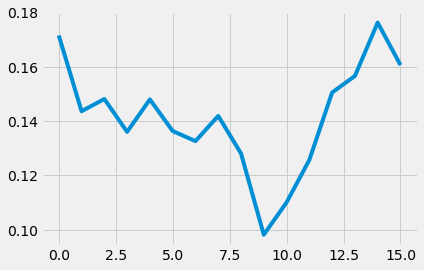

In [2488]:
plt.plot(df_us_tests['ratio'].values)

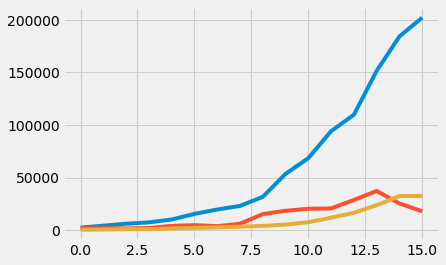

In [2489]:
plt.plot(df_us_tests['tested'].values)
plt.plot(np.gradient(df_us_tests['tested'].values))
plt.plot(df_us_tests['positive'].values)

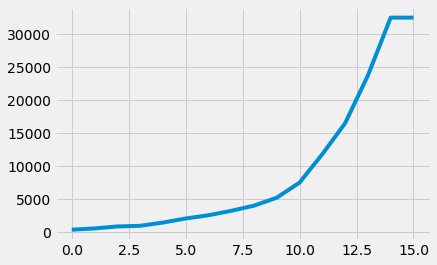

In [2490]:
plt.plot(df_us_tests['positive'].values)

In [2491]:
np.max(np.gradient(df_us_tests['tested'].values))

37256.0

In [2492]:
np.max(df_us_tests['positive'].values)

32449

In [2493]:
df_us_tests['positive'].values[-2]

32449

In [2494]:
X1 = 5
Y1 = np.gradient(df_us_tests['tested'].values)[X1]
X2 = 13
Y2 = np.gradient(df_us_tests['tested'].values)[X2]
points = [(X1,Y1),(X2,Y2)]
degree = 3

print(f'X1,Y1 {X1,Y1}')
print(f'X2,Y2 {X2,Y2}')
test_base,A_factor = determine_R0(points)

X1,Y1 (5, 4751.0)
X2,Y2 (13, 37256.0)


In [2495]:
test_base

1.2936041474870121

In [2496]:
line,coefs = return_polyfit(np.array([X1,X2]),np.array([Y1,Y2]),degree)
# poly.polyval(down_day, coefs)

/anaconda3/envs/torch/lib/python3.6/site-packages/ipykernel_launcher.py:27: RankWarning: The fit may be poorly conditioned


In [2497]:
def decay_to_max(max_daily,last_point,duration):
    points = []
    new_point = last_point + ((max_daily - last_point) / 2)
    print('last_point',last_point,'new_point',new_point)
    for _ in range(duration):
        points.append(new_point)
        new_point += (max_daily - new_point) / 2
    return np.array(points)

In [2622]:
Ys

array([  1311.52941033,   1696.59988476,   2194.72864755,   2839.11008108,
         3672.68457606,   4751.        ,   6145.91330471,   7950.37894107,
        10284.64317226,  13304.25706306,  17210.44211601,  22263.49930135,
        28800.15503381,  37256.        ,  48194.51611878,  62344.62593738,
        80649.26668612, 104328.22587695, 134959.42569438])

last_point 134959.42569438403 new_point 142479.71284719202


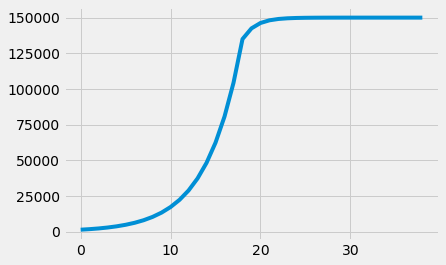

In [2499]:
max_daily_tests = 150*1e+3
Ys = np.power(test_base,np.arange(19))*A_factor
end_ys = decay_to_max(max_daily_tests,Ys[-1],20)

projected_tests = np.concatenate([Ys,end_ys])
plt.plot(projected_tests)
# plt.yscale('log')

## Looking at infection cases

In [2500]:
def gen_infection_scurve(params):
    population,R0,asymptomatic_period,hospitalization_rate,inflection_point,R0_reduction,base_R0,hospital_days = params.values()
    day = 0
    total_infections = population
    current_infections = population
    hospitalized_patients = deque(maxlen=hospital_days)
    while 1:
        if day < inflection_point*asymptomatic_period:
            current_infections = R0 * current_infections
            total_infections += current_infections
            day += asymptomatic_period
            hospitalized_patients.append(current_infections * hospitalization_rate)
    #         print(f'hospitalized_patients {sum(hospitalized_patients)}')
        else:
            current_infections = R0 * current_infections
            total_infections += current_infections
            day += asymptomatic_period
            hospitalized_patients.append(current_infections * hospitalization_rate)
            R0 += (base_R0 - R0) / 2
            R0 = max(R0,base_R0)
        print(f'Day {day}, Current_infections: {current_infections:.0f}, total_infections: {total_infections:.0f}, Hospitalized_patients {sum(hospitalized_patients):.2f}, R0 {R0:.2f}')
        yield (day,current_infections,total_infections,sum(hospitalized_patients),R0)
    

# Making the simulation more detailed

- add influx from travelers. Explains the reason why cases stay around 40-100
- add testing percentages. Start at zero and increase.
- add positive and negative rates for covid. 
- Assume hospitalized patients are always tested.

March 21
- 151k tests
- 26k cases

In [2501]:
def return_testing_rate():
    pass

def gen_infection_adv(params):
    population,R0,asymptomatic_period,hospitalization_rate,inflection_point,R0_reduction,base_R0,hospital_days,tests,pos_rate,traveler_cases = params.values()
    day = 0
    down_day = 0
    total_confirmed = 0
    daily_confirmed = 0
    total_tests = 0
    current_tests = 0
    total_infections = population
    current_infections = population
    hospitalized_patients = deque(maxlen=hospital_days)
    while 1:
        if day < inflection_point*asymptomatic_period:
            current_infections = R0 * current_infections
            total_infections += current_infections
            day += asymptomatic_period
            hospitalized_patients.append(current_infections * hospitalization_rate)
        else:
            current_infections = R0 * current_infections
            total_infections += current_infections
            day += asymptomatic_period
            down_day += asymptomatic_period
            hospitalized_patients.append(current_infections * hospitalization_rate)
            R0 += (base_R0 - R0) / 2
            R0 = max(R0,base_R0)
            current_tests = tests[down_day]
            total_tests += current_tests
            daily_confirmed = current_tests * pos_rate
            total_confirmed += daily_confirmed
        print(f'Day {day}, Total tests {total_tests:.0f}, Daily_tests {current_tests:.0f}, Daily confirmed {daily_confirmed:.0f}, Total confirmed {total_confirmed:.0f}, Current_infections: {current_infections:.0f}, total_infections: {total_infections:.0f}, Hospitalized_patients {sum(hospitalized_patients):.0f}, R0 {R0:.2f}')
        yield (day,current_infections,total_infections,sum(hospitalized_patients),R0,daily_confirmed,total_confirmed,current_tests,total_tests)
    

In [2619]:
population = 5
R0 = 2.3
asymptomatic_period = 5
hospitalization_rate = 0.05
inflection_point = 9 # of cycles since to Jan 24 to March 16
R0_reduction = 0.9
base_R0 = 0.80
hospital_days = 14
traveler_cases = 50

adv_params = {'population':population,
         'R0':R0,
         'asymptomatic_period':asymptomatic_period,
         'hospitalization_rate':hospitalization_rate,
         'inflection_point':inflection_point,
         'R0_reduction':R0_reduction,
         'base_R0':base_R0,
          'hospital_days': hospital_days,
          'tests':projected_tests,
          'pos_rate':0.14,
        'traveler_cases':traveler_cases
         }

In [2621]:
advGenerator = gen_infection_adv(adv_params)
advcurve_data = []
for _ in range(16):
    advcurve_data.append(next(advGenerator))

Day 5, Total tests 0, Daily_tests 0, Daily confirmed 0, Total confirmed 0, Current_infections: 12, total_infections: 16, Hospitalized_patients 1, R0 2.30
Day 10, Total tests 0, Daily_tests 0, Daily confirmed 0, Total confirmed 0, Current_infections: 26, total_infections: 43, Hospitalized_patients 2, R0 2.30
Day 15, Total tests 0, Daily_tests 0, Daily confirmed 0, Total confirmed 0, Current_infections: 61, total_infections: 104, Hospitalized_patients 5, R0 2.30
Day 20, Total tests 0, Daily_tests 0, Daily confirmed 0, Total confirmed 0, Current_infections: 140, total_infections: 244, Hospitalized_patients 12, R0 2.30
Day 25, Total tests 0, Daily_tests 0, Daily confirmed 0, Total confirmed 0, Current_infections: 322, total_infections: 566, Hospitalized_patients 28, R0 2.30
Day 30, Total tests 0, Daily_tests 0, Daily confirmed 0, Total confirmed 0, Current_infections: 740, total_infections: 1306, Hospitalized_patients 65, R0 2.30
Day 35, Total tests 0, Daily_tests 0, Daily confirmed 0, Tot

In [2504]:
params = {'population':population,
         'R0':R0,
         'asymptomatic_period':asymptomatic_period,
         'hospitalization_rate':hospitalization_rate,
         'inflection_point':inflection_point,
         'R0_reduction':R0_reduction,
         'base_R0':base_R0,
          'hospital_days': hospital_days
         }
curveGenerator = gen_infection_scurve(params)
scurve_data = []
for _ in range(25):
    scurve_data.append(next(curveGenerator))

Day 5, Current_infections: 12, total_infections: 16, Hospitalized_patients 0.58, R0 2.30
Day 10, Current_infections: 26, total_infections: 43, Hospitalized_patients 1.90, R0 2.30
Day 15, Current_infections: 61, total_infections: 104, Hospitalized_patients 4.94, R0 2.30
Day 20, Current_infections: 140, total_infections: 244, Hospitalized_patients 11.94, R0 2.30
Day 25, Current_infections: 322, total_infections: 566, Hospitalized_patients 28.03, R0 2.30
Day 30, Current_infections: 740, total_infections: 1306, Hospitalized_patients 65.04, R0 2.30
Day 35, Current_infections: 1702, total_infections: 3008, Hospitalized_patients 150.16, R0 2.30
Day 40, Current_infections: 3916, total_infections: 6924, Hospitalized_patients 345.93, R0 2.30
Day 45, Current_infections: 9006, total_infections: 15929, Hospitalized_patients 796.22, R0 2.30
Day 50, Current_infections: 20713, total_infections: 36643, Hospitalized_patients 1831.88, R0 2.30
Day 55, Current_infections: 47640, total_infections: 84283, Ho

In [2505]:
def plot_projections(projections):
    data = [[] for _ in range(len(projections[0]))]
    print(len(data))
    for projection in projections:
        print('projection',projection)
        for i,d in enumerate(projection):
            data[i].append(d)
    return data

9
projection (5, 11.5, 16.5, 0.5750000000000001, 2.3, 0, 0, 0, 0)
projection (10, 26.45, 42.95, 1.8975, 2.3, 0, 0, 0, 0)
projection (15, 60.834999999999994, 103.785, 4.9392499999999995, 2.3, 0, 0, 0, 0)
projection (20, 139.92049999999998, 243.70549999999997, 11.935274999999999, 2.3, 0, 0, 0, 0)
projection (25, 321.8171499999999, 565.5226499999999, 28.026132499999996, 2.3, 0, 0, 0, 0)
projection (30, 740.1794449999998, 1305.7020949999996, 65.03510474999999, 2.3, 0, 0, 0, 0)
projection (35, 1702.4127234999994, 3008.1148184999993, 150.15574092499998, 2.3, 0, 0, 0, 0)
projection (40, 3915.5492640499983, 6923.664082549998, 345.9332041274999, 2.3, 0, 0, 0, 0)
projection (45, 9005.763307314995, 15929.427389864994, 796.2213694932498, 2.3, 0, 0, 0, 0)
projection (50, 20713.25560682449, 36642.68299668948, 1831.8841498344743, 2.3, 0, 0, 0, 0)
projection (55, 47640.48789569632, 84283.1708923858, 4213.90854461929, 1.5499999999999998, 665.1400000000001, 665.1400000000001, 4751.0, 4751.0)
projection 

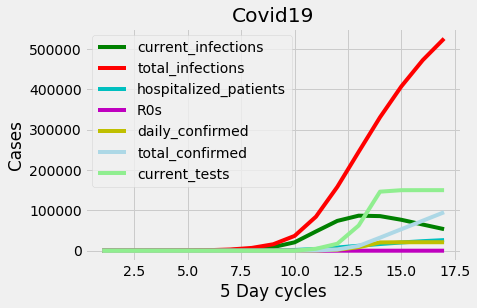

In [2506]:
values = plot_projections(advcurve_data)
# (day,current_infections,total_infections,sum(hospitalized_patients),R0,daily_confirmed,total_confirmed,current_tests,total_tests)
labels = ['days','current_infections','total_infections','hospitalized_patients','R0s','daily_confirmed','total_confirmed','current_tests','total_tests']
colors = ['b','g','r','c','m','y','lightblue','lightgreen','gray','teal']
for i,x in enumerate(values[1:-1],1):
    epochs = range(1,len(x)+1)
    plt.plot(epochs,x,colors[i],label=f"{labels[i]}")
    plt.title('Covid19')
    plt.xlabel('5 Day cycles')
    plt.ylabel('Cases')
    plt.legend()
plt.show()

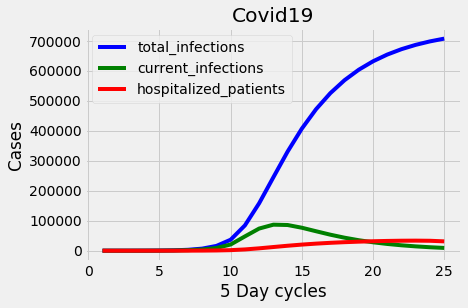

In [2507]:
days,current_infections,total_infections,hospitalized_patients,R0s = [],[],[],[],[]
for point in scurve_data:
    day,current_infection,total_infection,hospitalized_patient,R0 = point
    days.append(day)
    current_infections.append(current_infection)
    total_infections.append(total_infection)
    hospitalized_patients.append(hospitalized_patient)
    R0s.append(R0)
    
values = [total_infections,current_infections,hospitalized_patients,R0s,days]
labels = ['total_infections','current_infections','hospitalized_patients','R0s','days']
colors = ['b','g','r','c','m','y','lightblue','lightgreen','gray','teal']
for i,x in enumerate(values[:-2]):
    epochs = range(1,len(x)+1)
    plt.plot(epochs,x,colors[i],label=f"{labels[i]}")
    plt.title('Covid19')
    plt.xlabel('5 Day cycles')
    plt.ylabel('Cases')
    plt.legend()
plt.show()

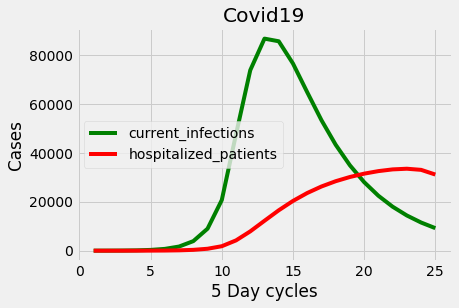

In [2508]:
for i,x in enumerate(values[1:-2],1):
    epochs = range(1,len(x)+1)
    plt.plot(epochs,x,colors[i],label=f"{labels[i]}")
    plt.title('Covid19')
    plt.xlabel('5 Day cycles')
    plt.ylabel('Cases')
    plt.legend()
plt.show()

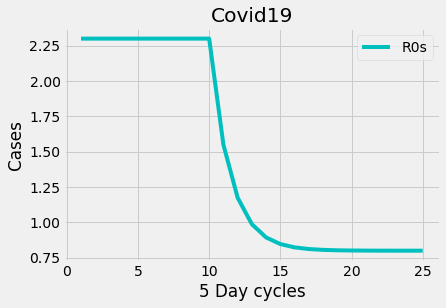

In [2509]:
for i,x in enumerate(values[3:4],3):
    epochs = range(1,len(x)+1)
    plt.plot(epochs,x,colors[i],label=f"{labels[i]}")
    plt.title('Covid19')
    plt.xlabel('5 Day cycles')
    plt.ylabel('Cases')
    plt.legend()
plt.show()

In [2510]:
def gen_infections(population,R0,asymptomatic_period,hospitalization_rate):
    day = 0
    total_infections = population
    current_infections = population
    hospitalized_patients = deque(maxlen=10)
    while 1:
        current_infections = R0 * current_infections
        total_infections += current_infections
        day += asymptomatic_period
        hospitalized_patients.append(current_infections * hospitalization_rate)
#         print(f'hospitalized_patients {sum(hospitalized_patients)}')
        print(f'Day {day}, Current_infections: {current_infections:.0f}, total_infections: {total_infections:.0f}, Hospitalized_patients {sum(hospitalized_patients):.2f}')
        yield total_infections
    

In [2511]:
population = 3
R0 = 2.3
asymptomatic_period = 5
hospitalization_rate = 0.05
generator = gen_infections(population,Rn,asymptomatic_period,hospitalization_rate)

In [2512]:
for i in range(1,17):
    next(generator)
#     print(f'Infected population {next(generator)}, Day {i*5}')

Day 5, Current_infections: 7, total_infections: 10, Hospitalized_patients 0.34
Day 10, Current_infections: 16, total_infections: 26, Hospitalized_patients 1.14
Day 15, Current_infections: 37, total_infections: 62, Hospitalized_patients 2.96
Day 20, Current_infections: 84, total_infections: 146, Hospitalized_patients 7.16
Day 25, Current_infections: 193, total_infections: 339, Hospitalized_patients 16.82
Day 30, Current_infections: 444, total_infections: 783, Hospitalized_patients 39.02
Day 35, Current_infections: 1021, total_infections: 1805, Hospitalized_patients 90.09
Day 40, Current_infections: 2349, total_infections: 4154, Hospitalized_patients 207.56
Day 45, Current_infections: 5403, total_infections: 9558, Hospitalized_patients 477.73
Day 50, Current_infections: 12428, total_infections: 21986, Hospitalized_patients 1099.13
Day 55, Current_infections: 28584, total_infections: 50570, Hospitalized_patients 2528.00
Day 60, Current_infections: 65744, total_infections: 116314, Hospital

## Graphs with different initial populations

Day 5, Current_infections: 2, total_infections: 3, Hospitalized_patients 0.11
Day 10, Current_infections: 5, total_infections: 9, Hospitalized_patients 0.38
Day 15, Current_infections: 12, total_infections: 21, Hospitalized_patients 0.99
Day 20, Current_infections: 28, total_infections: 49, Hospitalized_patients 2.39
Day 25, Current_infections: 64, total_infections: 113, Hospitalized_patients 5.61
Day 30, Current_infections: 148, total_infections: 261, Hospitalized_patients 13.01
Day 35, Current_infections: 340, total_infections: 602, Hospitalized_patients 30.03
Day 40, Current_infections: 783, total_infections: 1385, Hospitalized_patients 69.19
Day 45, Current_infections: 1801, total_infections: 3186, Hospitalized_patients 159.24
Day 50, Current_infections: 4143, total_infections: 7329, Hospitalized_patients 366.38
Day 55, Current_infections: 9528, total_infections: 16857, Hospitalized_patients 842.67
Day 60, Current_infections: 21915, total_infections: 38771, Hospitalized_patients 19

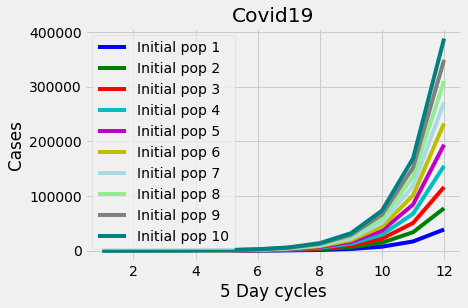

In [2513]:
alternates = []
data_points = {i:[] for i in range(10)}
for i in range(1,11):
    alternates.append(gen_infections(i,R0,asymptomatic_period,hospitalization_rate))
for i,gen in enumerate(alternates):
    for _ in range(1,13):
        data_points[i].append(next(gen))
    

colors = ['b','g','r','c','m','y','lightblue','lightgreen','gray','teal']
xs = data_points.values()
for i,x in enumerate(xs):
    epochs = range(1,len(x)+1)
    plt.plot(epochs,x,colors[i],label=f"Initial pop {i+1}")
    plt.title('Covid19')
    plt.xlabel('5 Day cycles')
    plt.ylabel('Cases')
    plt.legend()
plt.show()

## Different R0 values with pop 1

In [2514]:
R0s = np.linspace(2,3,11)

Day 5, Current_infections: 2, total_infections: 3, Hospitalized_patients 0.10
Day 10, Current_infections: 4, total_infections: 7, Hospitalized_patients 0.30
Day 15, Current_infections: 8, total_infections: 15, Hospitalized_patients 0.70
Day 20, Current_infections: 16, total_infections: 31, Hospitalized_patients 1.50
Day 25, Current_infections: 32, total_infections: 63, Hospitalized_patients 3.10
Day 30, Current_infections: 64, total_infections: 127, Hospitalized_patients 6.30
Day 35, Current_infections: 128, total_infections: 255, Hospitalized_patients 12.70
Day 40, Current_infections: 256, total_infections: 511, Hospitalized_patients 25.50
Day 45, Current_infections: 512, total_infections: 1023, Hospitalized_patients 51.10
Day 50, Current_infections: 1024, total_infections: 2047, Hospitalized_patients 102.30
Day 55, Current_infections: 2048, total_infections: 4095, Hospitalized_patients 204.60
Day 60, Current_infections: 4096, total_infections: 8191, Hospitalized_patients 409.20
Day 5

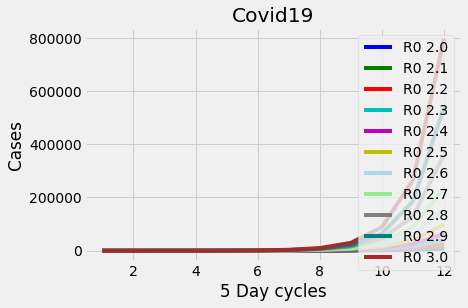

In [2515]:
alternates = []
data_points = {i:[] for i in range(11)}
for R0 in R0s:
    alternates.append(gen_infections(1,R0,asymptomatic_period,hospitalization_rate))
for i,gen in enumerate(alternates):
    for _ in range(1,13):
        data_points[i].append(next(gen))
    

colors = ['b','g','r','c','m','y','lightblue','lightgreen','gray','teal','brown']
xs = data_points.values()
for i,x in enumerate(xs):
    epochs = range(1,len(x)+1)
    plt.plot(epochs,x,colors[i],label=f"R0 {R0s[i]}")
    plt.title('Covid19')
    plt.xlabel('5 Day cycles')
    plt.ylabel('Cases')
    plt.legend()
plt.show()

# WHO projected R0

Day 5, Current_infections: 2, total_infections: 3, Hospitalized_patients 0.10
Day 10, Current_infections: 4, total_infections: 7, Hospitalized_patients 0.30
Day 15, Current_infections: 8, total_infections: 15, Hospitalized_patients 0.70
Day 20, Current_infections: 16, total_infections: 31, Hospitalized_patients 1.50
Day 25, Current_infections: 32, total_infections: 63, Hospitalized_patients 3.10
Day 30, Current_infections: 64, total_infections: 127, Hospitalized_patients 6.30
Day 35, Current_infections: 128, total_infections: 255, Hospitalized_patients 12.70
Day 40, Current_infections: 256, total_infections: 511, Hospitalized_patients 25.50
Day 45, Current_infections: 512, total_infections: 1023, Hospitalized_patients 51.10
Day 50, Current_infections: 1024, total_infections: 2047, Hospitalized_patients 102.30
Day 55, Current_infections: 2048, total_infections: 4095, Hospitalized_patients 204.60
Day 60, Current_infections: 4096, total_infections: 8191, Hospitalized_patients 409.20
Day 5

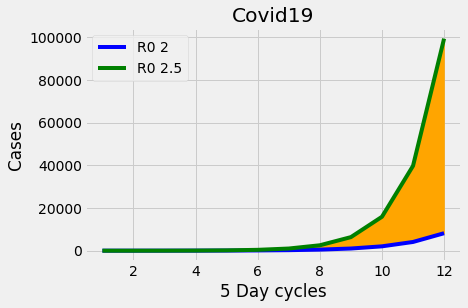

In [2516]:
WHO_R0s = [2,2.5]

alternates = []
data_points = {i:[] for i in range(2)}
for R0 in WHO_R0s:
    alternates.append(gen_infections(1,R0,asymptomatic_period,hospitalization_rate))
for i,gen in enumerate(alternates):
    for _ in range(1,13):
        data_points[i].append(next(gen))

print(f'Max {np.max(data_points[0])}, {np.max(data_points[1])}')

colors = ['b','g','r','c','m','y','lightblue','lightgreen','gray','teal','brown']
epochs = range(1,len(data_points[0])+1)
plt.plot(epochs,data_points[0],colors[0],label=f"R0 {WHO_R0s[0]}")
plt.plot(epochs,data_points[1],colors[1],label=f"R0 {WHO_R0s[1]}")
plt.fill_between(epochs, data_points[0], data_points[1],color='orange')
plt.title('Covid19')
plt.xlabel('5 Day cycles')
plt.ylabel('Cases')
# plt.yscale("log")
plt.legend()
plt.show()

In [2517]:
points = [(0,699.5),(16,110)]
result = determine_R0(points)
print(f'result {result}')

result (0.890815592993061, 699.5)


# List all the contained countries

In [2518]:
general_df['Country/Region'].unique()

array(['Thailand', 'Japan', 'Singapore', 'Nepal', 'Malaysia', 'Canada',
       'Australia', 'Cambodia', 'Sri Lanka', 'Germany', 'Finland',
       'United Arab Emirates', 'Philippines', 'India', 'Italy', 'Sweden',
       'Spain', 'Belgium', 'Egypt', 'Lebanon', 'Iraq', 'Oman',
       'Afghanistan', 'Bahrain', 'Kuwait', 'Algeria', 'Croatia',
       'Switzerland', 'Austria', 'Israel', 'Pakistan', 'Brazil',
       'Georgia', 'Greece', 'North Macedonia', 'Norway', 'Romania',
       'Estonia', 'San Marino', 'Belarus', 'Iceland', 'Lithuania',
       'Mexico', 'New Zealand', 'Nigeria', 'Ireland', 'Luxembourg',
       'Monaco', 'Qatar', 'Ecuador', 'Azerbaijan', 'Armenia',
       'Dominican Republic', 'Indonesia', 'Portugal', 'Andorra', 'Latvia',
       'Morocco', 'Saudi Arabia', 'Senegal', 'Argentina', 'Chile',
       'Jordan', 'Ukraine', 'Hungary', 'Liechtenstein', 'Poland',
       'Tunisia', 'Bosnia and Herzegovina', 'Slovenia', 'South Africa',
       'Bhutan', 'Cameroon', 'Colombia', 'Costa R

In [2519]:
France = general_df[general_df['Country/Region'] == 'France']
Spain = general_df[general_df['Country/Region'] == 'Spain']
Italy = general_df[general_df['Country/Region'] == 'Italy']
US = general_df[general_df['Country/Region'] == 'US']
China = general_df[general_df['Country/Region'] == 'China']

# USA

In [2520]:
US

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20
98,Washington,US,47.4009,-121.4905,0,0,0,0,0,0,...,568,572,643,904,1076,1014,1376,1524,1793,1996
99,New York,US,42.1657,-74.9481,0,0,0,0,0,0,...,421,525,732,967,1706,2495,5365,8310,11710,15793
100,California,US,36.1162,-119.6816,0,0,0,0,0,0,...,282,340,426,557,698,751,952,1177,1364,1642
101,Massachusetts,US,42.2302,-71.5301,0,0,0,0,0,0,...,123,138,164,197,218,218,328,413,525,646
102,Diamond Princess,US,35.4437,139.6380,0,0,0,0,0,0,...,46,46,46,47,47,47,47,49,49,49
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399,"New Castle, DE",US,39.5393,-75.6674,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
414,Alabama,US,32.3182,-86.9023,0,0,0,0,0,0,...,5,6,12,29,39,46,78,83,131,138
417,Puerto Rico,US,18.2208,-66.5901,0,0,0,0,0,0,...,0,3,5,5,5,5,5,14,21,23
431,Guam,US,13.4443,144.7937,0,0,0,0,0,0,...,0,0,3,3,3,5,12,14,15,27


In [2521]:
US_cases = US.iloc[:,4:]

In [2522]:
US_totals = US_cases.sum(axis=0).values

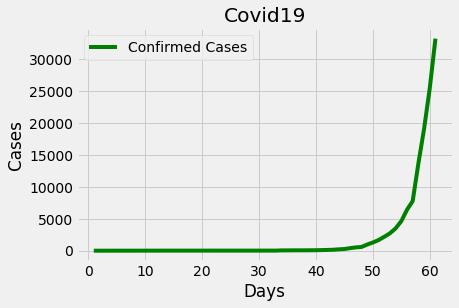

In [2523]:
plot_totals(US_totals)

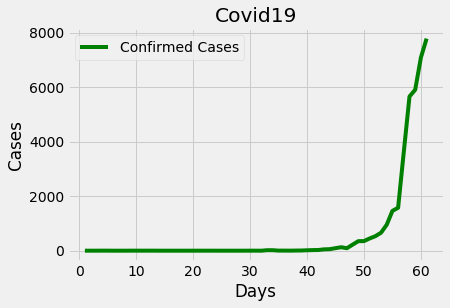

In [2524]:
plot_totals(np.gradient(US_totals))

In [2525]:
peak_US_index = np.argmax(np.gradient(US_totals))
print(f'Peak index {peak_US_index}')
print(f'Confirmed cases {US_totals[peak_US_index]}')

Peak index 60
Confirmed cases 33272


In [2618]:
US_first_case_index = np.min(np.nonzero(US_totals))
print(f'Date of first case {US.columns[4+first_case_index]}')
print(f'Date of peak {US.columns[peak_US_index]}')
US_start_date = parse_date(US.columns[4+first_case_index])
US_peak_date = parse_date(US.columns[peak_US_index])
US_actual_start = datetime.datetime(2020,1,20)

print(f'Duration in days {US_peak_date - US_start_date}')
print(f'Duration since first case {datetime.datetime.now() - US_actual_start}')

Date of first case 2/1/20
Date of peak 3/18/20
Duration in days 46 days, 0:00:00
Duration since first case 63 days, 9:51:47.235541


# Italy

In [2527]:
Italy

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20
16,NaN,Italy,43.0,12.0,0,0,0,0,0,0,...,17660,21157,24747,27980,31506,35713,41035,47021,53578,59138


In [2528]:
italy_cases = Italy.iloc[:,4:]

In [2529]:
italy_totals = italy_cases.values[0]

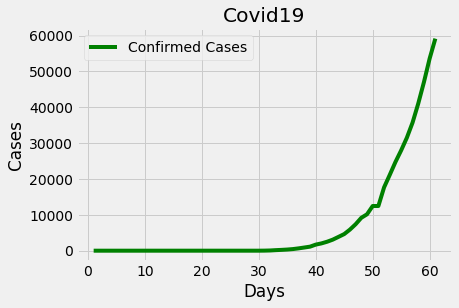

In [2530]:
plot_totals(italy_totals)

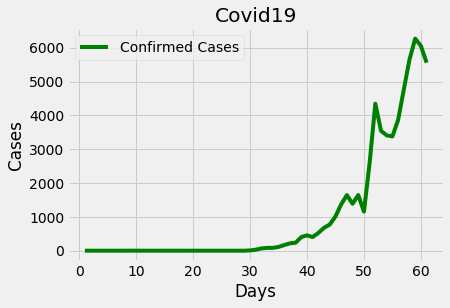

In [2531]:
plot_totals(np.gradient(italy_totals))

In [2532]:
peak_italy_index = np.argmax(np.gradient(italy_totals))
print(f'Peak index {peak_italy_index}')
print(f'Confirmed cases {italy_totals[peak_italy_index]}')

Peak index 58
Confirmed cases 47021


In [2533]:
italy_first_case_index = np.min(np.nonzero(italy_totals))
italy_start_date = parse_date(Italy.columns[4+first_case_index])
italy_peak_date = parse_date(Italy.columns[4+peak_italy_index])
print(f'Date of first case {italy_start_date}')
print(f'Date of peak {italy_peak_date}')

print(f'Duration until peak {italy_peak_date - italy_start_date}')
print(f'Duration since first case {datetime.datetime.now() - italy_start_date}')

Date of first case 2020-02-01 00:00:00
Date of peak 2020-03-20 00:00:00
Duration until peak 48 days, 0:00:00
Duration since first case 51 days, 9:26:13.703053


# France

In [2534]:
France

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20
157,France,France,46.2276,2.2137,0,0,2,3,3,3,...,3661,4469,4499,6633,7652,9043,10871,12612,14282,16018
198,St Martin,France,18.0708,-63.0501,0,0,0,0,0,0,...,2,2,2,2,2,3,4,4,4,4
205,Saint Barthelemy,France,17.9000,-62.8333,0,0,0,0,0,0,...,1,1,1,3,3,3,3,3,3,3
405,French Polynesia,France,-17.6797,149.4068,0,0,0,0,0,0,...,3,3,3,3,3,3,6,11,15,15
430,French Guiana,France,3.9339,-53.1258,0,0,0,0,0,0,...,5,5,7,11,11,11,11,15,18,18
438,Mayotte,France,-12.8275,45.1662,0,0,0,0,0,0,...,0,0,1,1,1,3,3,6,7,11
442,Guadeloupe,France,16.2500,-61.5833,0,0,0,0,0,0,...,1,1,3,6,18,27,33,45,53,56
450,Reunion,France,-21.1351,55.2471,0,0,0,0,0,0,...,5,6,7,9,9,12,14,28,45,47
462,New Caledonia,France,-20.9043,165.6180,0,0,0,0,0,0,...,0,0,0,0,0,0,2,2,4,4


In [2535]:
french_cases = France.iloc[:,4:]

In [2536]:
french_total = french_cases.sum(axis=0).values

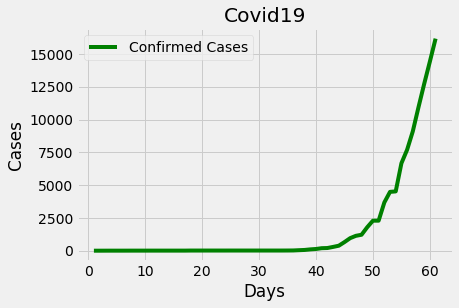

In [2537]:
plot_totals(french_total)

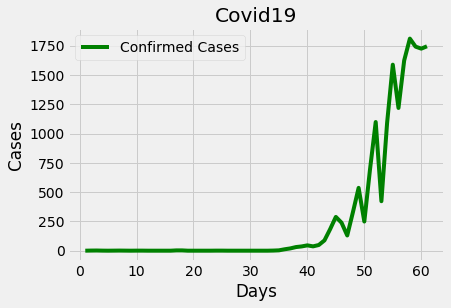

In [2538]:
plot_totals(np.gradient(french_total))

In [2539]:
peak_france_index = np.argmax(np.gradient(french_total))
print(f'Peak index {peak_france_index}')
print(f'Confirmed cases {french_total[peak_france_index]}')

Peak index 57
Confirmed cases 10947


In [2540]:
first_case_index = np.min(np.nonzero(french_total))
france_start_date = parse_date(France.columns[4+first_case_index])
france_peak_date = parse_date(France.columns[4+peak_france_index])
print(f'Start index {first_case_index}')
print(f'Peak index {peak_france_index}')
print(f'Date of first case {france_start_date}')
print(f'Date of peak {france_peak_date}')

print(f'Duration in days {france_peak_date - france_start_date}')
print(f'Duration since first case {datetime.datetime.now() - italy_start_date}')

Start index 2
Peak index 57
Date of first case 2020-01-24 00:00:00
Date of peak 2020-03-19 00:00:00
Duration in days 55 days, 0:00:00
Duration since first case 51 days, 9:26:14.442738


# Spain

In [2541]:
Spain

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20
18,NaN,Spain,40.0,-4.0,0,0,0,0,0,0,...,5232,6391,7798,9942,11748,13910,17963,20410,25374,28768


In [2542]:
spain_cases = Spain.iloc[:,4:]

In [2543]:
spain_totals = spain_cases.values[0]

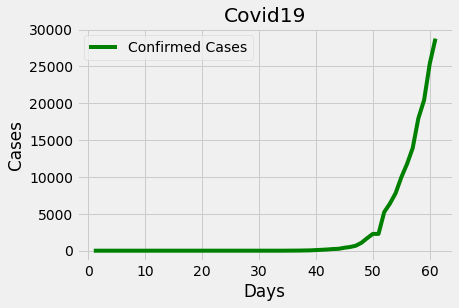

In [2544]:
plot_totals(spain_totals)

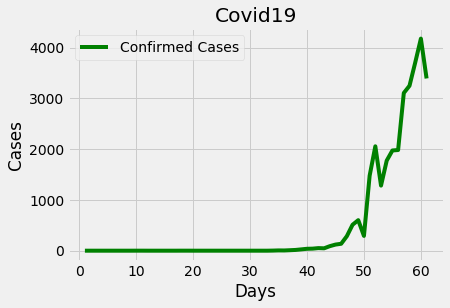

In [2545]:
plot_totals(np.gradient(spain_totals))

#### Peak spain

In [2546]:
peak_spain_index = np.argmax(np.gradient(spain_totals))
print(f'Peak index {peak_spain_index}')
print(f'Confirmed cases {spain_totals[peak_spain_index]}')

Peak index 59
Confirmed cases 25374


In [2547]:
first_case_index = np.min(np.nonzero(spain_totals))
spain_start_date = parse_date(Spain.columns[4+first_case_index])
spain_peak_date = parse_date(Spain.columns[4+peak_spain_index])
print(f'Date of first case {Spain.columns[4+first_case_index]}')
print(f'Date of peak {Spain.columns[4+peak_spain_index]}')\

print(f'Duration in days {spain_peak_date - spain_start_date}')
print(f'Duration since first case {datetime.datetime.now() - spain_start_date}')

Date of first case 2/1/20
Date of peak 3/21/20
Duration in days 49 days, 0:00:00
Duration since first case 51 days, 9:26:15.208298


# China

Data is messy because of the big spike when they changed how they track the cases. better to average that data over the previous several datapoints to smooth out the curve

In [2548]:
China

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20
154,Hubei,China,30.9756,112.2707,444,444,549,761,1058,1423,...,67786,67790,67794,67798,67799,67800,67800,67800,67800,67800
158,Guangdong,China,23.3417,113.4244,26,32,53,78,111,151,...,1356,1356,1360,1361,1364,1370,1378,1395,1400,1407
159,Henan,China,33.8820,113.6140,5,5,9,32,83,128,...,1273,1273,1273,1273,1273,1273,1273,1273,1273,1273
160,Zhejiang,China,29.1832,120.0934,10,27,43,62,104,128,...,1215,1227,1231,1231,1232,1232,1233,1234,1236,1237
161,Hunan,China,27.6104,111.7088,4,9,24,43,69,100,...,1018,1018,1018,1018,1018,1018,1018,1018,1018,1018
162,Anhui,China,31.8257,117.2264,1,9,15,39,60,70,...,990,990,990,990,990,990,990,990,990,990
163,Jiangxi,China,27.6140,115.7221,2,7,18,18,36,72,...,935,935,935,935,935,935,935,935,935,936
164,Shandong,China,36.3427,118.1498,2,6,15,27,46,75,...,760,760,760,760,761,761,761,762,764,766
166,Jiangsu,China,32.9711,119.4550,1,5,9,18,33,47,...,631,631,631,631,631,631,631,631,631,633
167,Chongqing,China,30.0572,107.8740,6,9,27,57,75,110,...,576,576,576,576,576,576,576,576,576,577


In [2549]:
china_cases = China.iloc[:,4:]

In [2550]:
china_cases.shape

(33, 61)

In [2551]:
china_totals = china_cases.sum(axis=0).values

# Fixing the china data

In [2552]:
data_spike_index = np.argmax(np.gradient(china_totals))

In [2553]:
data_spread_start = np.where(np.gradient(china_totals) == 3912.5)[0][0]

In [2554]:
print(f'data_spike_index {data_spike_index}, data_spread_start {data_spread_start}')

data_spike_index 22, data_spread_start 11


In [2555]:
print('Sum of the bad data gradients',sum(np.gradient(china_totals)[12:24]))
print('Average of the bad data gradients',sum(np.gradient(china_totals)[12:24]) / 13)
print('Sum of the bad data',sum(china_totals[12:24]))

Sum of the bad data gradients 49212.5
Average of the bad data gradients 3785.576923076923
Sum of the bad data 469955


## Goal is to spread the amounts in a cascade

In [2556]:
print(china_totals[12],china_totals[24])

19716 68413


In [2557]:
test = np.array([3786,4174,3728,3465,2922,2747,2615,2521,2404,2319,2210,2061])

In [2558]:
inputs = np.concatenate([np.array(china_totals[11]).reshape(1,),test])
print(sum(list(accumulate(inputs))))

469955


In [2559]:
print(np.sum(test),test.shape)

34952 (12,)


In [2560]:
china_part1 = china_totals[:11]
china_part2 = np.gradient(china_totals)[24:]

In [2561]:
inputs = np.concatenate([np.array(china_totals[11]).reshape(1,),test,china_part2])
print(inputs.astype(int))

[16630  3786  4174  3728  3465  2922  2747  2615  2521  2404  2319  2210
  2061  2077  2010  1849  1092   433   465   962   736   120   366   462
   423   381   378   502   390   164   125   138   152   116    66    45
    32    30    22    12    22    29    28    27    34    49    74    74
    73    92]


In [2562]:
china_inbetween = list(accumulate(inputs))

In [2563]:
print(china_inbetween)

[16630.0, 20416.0, 24590.0, 28318.0, 31783.0, 34705.0, 37452.0, 40067.0, 42588.0, 44992.0, 47311.0, 49521.0, 51582.0, 53659.5, 55670.0, 57519.0, 58611.5, 59044.5, 59510.0, 60472.0, 61208.0, 61328.0, 61694.0, 62156.5, 62579.5, 62960.5, 63338.5, 63840.5, 64230.5, 64395.0, 64520.0, 64658.0, 64810.0, 64926.5, 64993.0, 65038.0, 65070.0, 65100.5, 65123.0, 65135.0, 65157.5, 65186.5, 65214.5, 65242.0, 65276.5, 65325.5, 65399.5, 65474.0, 65547.5, 65639.5]


In [2564]:
print(sum(china_inbetween),sum(china_totals[12:24]))

2805009.5 469955


In [2565]:
new_china_totals = np.concatenate([china_part1,china_inbetween])

In [2566]:
print(new_china_totals.shape,china_totals.shape)
print(new_china_totals[12],new_china_totals[23])
print(china_totals[12],china_totals[23])

(61,) (61,)
20416.0 51582.0
19716 66358


In [2567]:
print(np.gradient(new_china_totals).astype(int))

[  95  186  381  577  735 1717 1605 1316 1857 1875 3414 4262 3980 3951
 3596 3193 2834 2681 2568 2462 2361 2264 2135 2069 2044 1929 1470  762
  449  713  849  428  243  414  442  402  379  440  446  277  144  131
  145  134   91   55   38   31   26   17   17   25   28   27   31   41
   61   74   74   82   92]


In [2568]:
new_china_totals

array([  548. ,   643. ,   920. ,  1406. ,  2075. ,  2877. ,  5509. ,
        6087. ,  8141. ,  9802. , 11891. , 16630. , 20416. , 24590. ,
       28318. , 31783. , 34705. , 37452. , 40067. , 42588. , 44992. ,
       47311. , 49521. , 51582. , 53659.5, 55670. , 57519. , 58611.5,
       59044.5, 59510. , 60472. , 61208. , 61328. , 61694. , 62156.5,
       62579.5, 62960.5, 63338.5, 63840.5, 64230.5, 64395. , 64520. ,
       64658. , 64810. , 64926.5, 64993. , 65038. , 65070. , 65100.5,
       65123. , 65135. , 65157.5, 65186.5, 65214.5, 65242. , 65276.5,
       65325.5, 65399.5, 65474. , 65547.5, 65639.5])

In [2569]:
np.gradient(china_totals)

array([   95. ,   186. ,   381.5,   577.5,   735.5,  1717. ,  1605. ,
        1316. ,  1857.5,  1875. ,  3414. ,  3912.5,  3538.5,  3862. ,
        3440. ,  3335. ,  3113.5,  2859.5,  2770. ,  2278.5,  1202.5,
        7754.5, 10799.5,  4259. ,  2077.5,  2010.5,  1849. ,  1092.5,
         433. ,   465.5,   962. ,   736. ,   120. ,   366. ,   462.5,
         423. ,   381. ,   378. ,   502. ,   390. ,   164.5,   125. ,
         138. ,   152. ,   116.5,    66.5,    45. ,    32. ,    30.5,
          22.5,    12. ,    22.5,    29. ,    28. ,    27.5,    34.5,
          49. ,    74. ,    74.5,    73.5,    92. ])

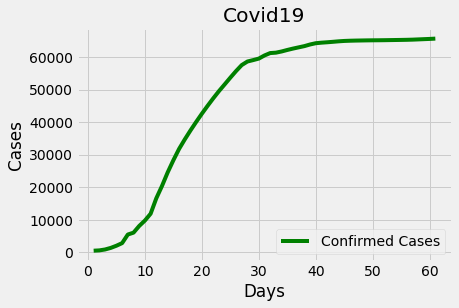

In [2570]:
plot_totals(new_china_totals)

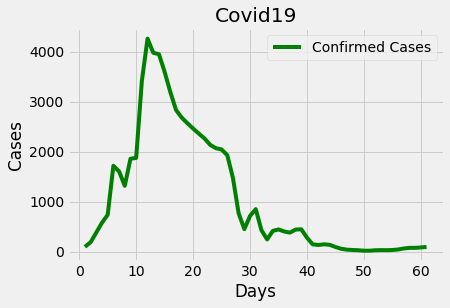

In [2571]:
plot_totals(np.gradient(new_china_totals))

# Find the R0 that fits the data the best

In [2572]:
chinaX1 = np.argmax(np.gradient(new_china_totals))
chinaY1 = np.gradient(new_china_totals)[chinaX1]
chinaX2 = 50
chinaY2 = np.gradient(new_china_totals)[chinaX2]
points = [(chinaX1,chinaY1),(chinaX2,chinaY2)]

print(f'X1,Y1 {chinaX1,chinaY1}')
print(f'X2,Y2 {chinaX2,chinaY2}')
china_R0 = determine_R0(points)


X1,Y1 (11, 4262.5)
X2,Y2 (50, 17.25)


In [2573]:
china_R0

(0.8682488630128049, 20164.05791131824)

In [2574]:
yPoints = np.array([graph_expo(x,points) for x in np.arange(50)])

In [2575]:
yPoints[:11] = 0

## Hubei specifically

population 58.5M

In [2576]:
Hubei = China.loc[China['Province/State'].str.contains('Hubei')]

In [2577]:
Hubei

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20
154,Hubei,China,30.9756,112.2707,444,444,549,761,1058,1423,...,67786,67790,67794,67798,67799,67800,67800,67800,67800,67800


In [2578]:
Hubei_totals = Hubei.values[0][4:]

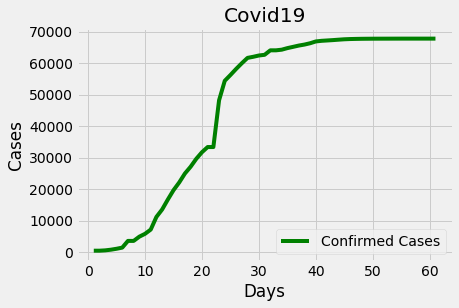

In [2579]:
plot_totals(Hubei_totals)

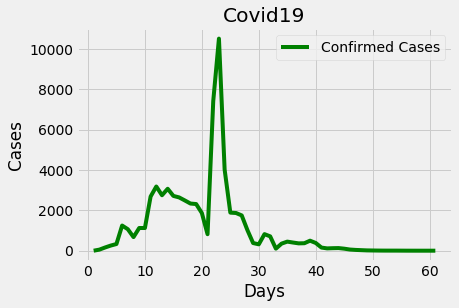

In [2580]:
plot_totals(np.gradient(Hubei_totals))

# Hubei peak

In [2581]:
Hubei

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20
154,Hubei,China,30.9756,112.2707,444,444,549,761,1058,1423,...,67786,67790,67794,67798,67799,67800,67800,67800,67800,67800


In [2582]:
Hubei_pop = 58.5*1e+7
peak_index = np.argmax(np.gradient(Hubei_totals))
Hubei_ratio = Hubei_totals/Hubei_pop
hubei_peak_date = datetime.datetime(2020,2,13)#parse_date(Hubei.columns[peak_index+4])
hubei_start_date = datetime.datetime(2019,11,17)
print(f'Peak index {peak_index}')
print(f'confirmed: {Hubei_totals[peak_index]}')
print(f'Total Hubei pop 58.5M')
print(f'confirmed: {Hubei_ratio[peak_index]}')
print(f'Peak Date {hubei_peak_date}')
print(f'Initial start Nov 17')
print(f'Number of days {(hubei_peak_date-hubei_start_date).days}')
print(f'Duration since first case {(datetime.datetime.now() - hubei_start_date).days}')



Peak index 22
confirmed: 48206
Total Hubei pop 58.5M
confirmed: 8.24034188034188e-05
Peak Date 2020-02-13 00:00:00
Initial start Nov 17
Number of days 88
Duration since first case 127


# Korea

## Pop 51.47M

## Seoul 9.77M

In [2583]:
def plot_comprehensive(data,labels,colors):
    epochs = range(1,len(data[0])+1)
    for i,label in enumerate(labels):
        plt.plot(epochs,data[i],colors[i],label=label)
    plt.title('Covid19')
    plt.xlabel('Days')
    plt.ylabel('Cases')
    plt.legend()
    plt.show()

In [2584]:
Seoul_pop = 9.77*1e+7

In [2585]:
korea_df.tail()

,date,time,test,negative,confirmed,released,deceased
58,2020-03-18,0,295647,270888,8413,1540,84
59,2020-03-19,0,307024,282555,8565,1947,91
60,2020-03-20,0,316664,292487,8652,2233,94
61,2020-03-21,0,327509,303006,8799,2612,102
62,2020-03-22,0,331780,308343,8897,2909,104


In [2586]:
tests = korea_df['test'].values
negative = korea_df['negative'].values
confirmed = korea_df['confirmed'].values
released = korea_df['released'].values
deceased = korea_df['deceased'].values
headers = korea_df.columns[2:]
korea_data = [tests,negative,confirmed,released,deceased]
colors = ['b','g','r','c','m','b']

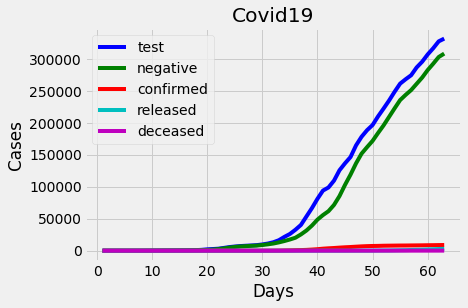

In [2587]:
plot_comprehensive(korea_data,headers,colors)

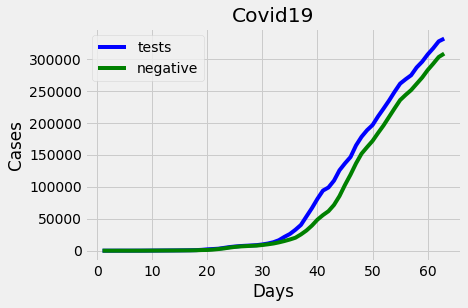

In [2588]:
plot_comprehensive([tests,negative],['tests','negative'],['b','g'])

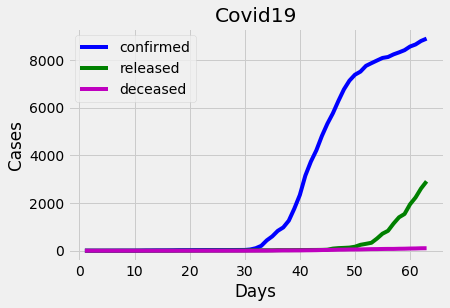

In [2589]:
plot_comprehensive([confirmed,released,deceased],['confirmed','released','deceased'],['b','g','m'])

# Derivatives

In [2590]:
tests_derivative = np.gradient(tests)
negative_derivative = np.gradient(negative)
confirmed_derivative = np.gradient(confirmed)
released_derivative = np.gradient(released)
deceased_derivative = np.gradient(deceased)
korea_derivatives = [tests_derivative,negative_derivative,confirmed_derivative,released_derivative,deceased_derivative]


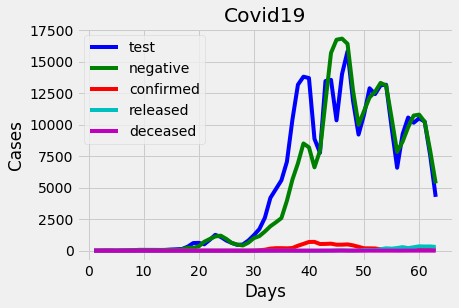

In [2591]:
plot_comprehensive(korea_derivatives,headers,colors)

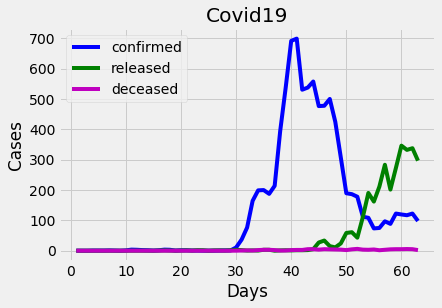

In [2592]:
plot_comprehensive([confirmed_derivative,released_derivative,deceased_derivative],['confirmed','released','deceased'],['b','g','m'])


# Ratios with population

In [2593]:
ratios = [d/Seoul_pop for d in korea_data]
ratio_derivatives = [np.gradient(d) for d in ratios]

# When did korea reach its peak

In [2594]:
peak_index = np.argmax(confirmed_derivative)
print(f'Peak index {peak_index}')
print(f'tests: {tests[peak_index]}')
print(f'negative: {negative[peak_index]}')
print(f'confirmed: {confirmed[peak_index]}')
print(f'released: {released[peak_index]}')
print(f'deceased: {deceased[peak_index]}')
print(f'Total Seoul pop 9.77M')
print(f'tests: {ratios[0][peak_index]}')
print(f'negative: {ratios[1][peak_index]}')
print(f'confirmed: {ratios[2][peak_index]}')
print(f'released: {ratios[3][peak_index]}')
print(f'deceased: {ratios[4][peak_index]}')

Peak index 40
tests: 94055
negative: 55723
confirmed: 3150
released: 28
deceased: 17
Total Seoul pop 9.77M
tests: 0.0009626919140225179
negative: 0.0005703480040941658
confirmed: 3.224155578300921e-05
released: 2.8659160696008186e-07
deceased: 1.7400204708290685e-07


In [2595]:
print(f'Korea first case {korea_df["date"][0]}')
print(f'Korea Peak date {korea_df["date"][peak_index]}')
korea_peak_date = datetime.date(2020,2,29)
korea_start_date = datetime.date(2020,1,20)
print(f'Days elapsed from start of transmission to peak {korea_peak_date - korea_start_date}')

Korea first case 2020-01-20
Korea Peak date 2020-02-29
Days elapsed from start of transmission to peak 40 days, 0:00:00


In [2596]:
print(confirmed_derivative[40])
print(confirmed_derivative[56])
print(confirmed_derivative[40:])

699.5
97.0
[699.5 531.  538.  558.  477.  478.  500.5 425.  307.5 189.5 186.5 178.
 112.  108.5  73.5  75.   97.   88.5 122.5 119.5 117.  122.5  98. ]


In [2597]:
len(confirmed)
day_5s = confirmed[::5]
[print(f'day {i*5},infected {pop}') for i,pop in enumerate(day_5s)]
day_5s_dir = confirmed_derivative[::5]
[print(f'day {i*5},infected {pop}') for i,pop in enumerate(day_5s_dir)]

day 0,infected 1
day 5,infected 2
day 10,infected 6
day 15,infected 16
day 20,infected 27
day 25,infected 28
day 30,infected 51
day 35,infected 833
day 40,infected 3150
day 45,infected 5766
day 50,infected 7513
day 55,infected 8126
day 60,infected 8652
day 0,infected 0.0
day 5,infected 0.5
day 10,infected 3.5
day 15,infected 1.5
day 20,infected 1.5
day 25,infected 0.0
day 30,infected 36.5
day 35,infected 187.5
day 40,infected 699.5
day 45,infected 478.0
day 50,infected 186.5
day 55,infected 75.0
day 60,infected 117.0


[None, None, None, None, None, None, None, None, None, None, None, None, None]

In [2598]:
generator = gen_infections(2,R0,asymptomatic_period,hospitalization_rate)
print(f'Infected population 1, Day 0')
for i in range(1,13):
    print(f'Infected population {next(generator)}, Day {i*5}')

Infected population 1, Day 0
Day 5, Current_infections: 5, total_infections: 7, Hospitalized_patients 0.25
Infected population 7.0, Day 5
Day 10, Current_infections: 12, total_infections: 20, Hospitalized_patients 0.88
Infected population 19.5, Day 10
Day 15, Current_infections: 31, total_infections: 51, Hospitalized_patients 2.44
Infected population 50.75, Day 15
Day 20, Current_infections: 78, total_infections: 129, Hospitalized_patients 6.34
Infected population 128.875, Day 20
Day 25, Current_infections: 195, total_infections: 324, Hospitalized_patients 16.11
Infected population 324.1875, Day 25
Day 30, Current_infections: 488, total_infections: 812, Hospitalized_patients 40.52
Infected population 812.46875, Day 30
Day 35, Current_infections: 1221, total_infections: 2033, Hospitalized_patients 101.56
Infected population 2033.171875, Day 35
Day 40, Current_infections: 3052, total_infections: 5085, Hospitalized_patients 254.15
Infected population 5084.9296875, Day 40
Day 45, Current_i

# Predictions

using time series to predict the next number of cases

## Inputs

More informative

- current number of confirmed cases
- number of tests so far

Less informative

- current number of confirmed cases

## Extract and shape the data

In [2599]:
unique_dates = italy_df['Date'].unique()
# print('unique_dates',unique_dates)
tests_preformed = []
tests_positive = []
for date in unique_dates:
    rows = italy_df[italy_df['Date'] == date]
    tests_preformed.append(rows['TestsPerformed'].sum())
    tests_positive.append(rows['TotalPositiveCases'].sum())

In [2600]:
korea_ml = np.stack([tests,confirmed])
italy_ml = np.stack([tests_preformed,tests_positive])
# china_ml =
usa_ml =  np.stack([USA_1df['posNeg'].values,USA_1df['positive'].values])

In [2601]:
print(korea_ml.shape,italy_ml.shape,usa_ml.shape)

(2, 63) (2, 28) (2, 19)


# Networks

In [2602]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable as V
from torch import optim
from torch.distributions import Categorical

In [2603]:
class Baseline(nn.Module):
    def __init__(self,seed,nS,nA,hidden_dims=(64,64),activation=F.leaky_relu):
        super(Baseline,self).__init__()
        self.activation = activation
        self.nS = nS
        self.nA = nA
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(nS,hidden_dims[0])
        self.fc2 = nn.Linear(hidden_dims[0],hidden_dims[1])
        self.fc3 = nn.Linear(hidden_dims[1],nA)
        
    def forward(self,state):
        x = state
        if not isinstance(state,torch.Tensor):
            x = torch.tensor(x,dtype=torch.float32)
            x = x.unsqueeze(0)
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        return self.fc3(x)
    
class Convnet(nn.Module):
    def __init__(self,seed,nS,nA,hidden_dims=(64,64),activation=F.leaky_relu):
        super(Baseline,self).__init__()
        self.activation = activation
        self.nS = nS
        self.nA = nA
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Conv2d(nS,hidden_dims[0])
        self.fc2 = nn.Linear(hidden_dims[0],hidden_dims[1])
        self.fc3 = nn.Linear(hidden_dims[1],nA)
        
    def forward(self,state,mask):
        x = state
        if not isinstance(state,torch.Tensor):
            x = torch.tensor(x,dtype=torch.float32)
            x = x.unsqueeze(0)
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        return self.fc3(x)

class LSTM():
    def __init__(self,seed,nS,nA,hidden_dims=(64,64),activation=F.leaky_relu):
        super(Baseline,self).__init__()
        self.activation = activation
        self.nS = nS
        self.nA = nA
        self.seed = torch.manual_seed(seed)
        self.lstm = nn.LSTM(nS,hidden_dims[0])
        
    def forward(self,state,mask):
        x = state
        if not isinstance(state,torch.Tensor):
            x = torch.tensor(x,dtype=torch.float32)
            x = x.unsqueeze(0)
        x,h = self.lstm(x)
        return x



# Train

In [2604]:
def run_sim(episodes,generator):
    infections = []
    for _ in range(episodes):
        day,current_infection,total_infection,hospitalized_patient,R0 = next(generator)
        infections.append(current_infection)
    return np.array(infections)
    
def get_loss(params,targets):  
    curveGenerator = gen_infection_scurve(params)
    episodes = len(targets)+params['inflection_point']
    infections = run_sim(episodes,curveGenerator)
    loss = np.sum(np.array(infections[params['inflection_point']:]) - targets)
    return loss

def tune_R0(params,training_params,targets,network):
    R0s = np.linspace(0.5,1,11)
    results = {R0:0 for R0 in R0s}
    for R0 in R0s:
        params['base_R0'] = R0
        loss = get_loss(params,targets)
        results[R0] = loss
#         print(f'loss {loss}, prev loss {prev_loss}, base_R0 {base_R0}')
#         print(f'new base {params["base_R0"]} * {0.0000001 * loss}')
#         params['base_R0'] = params['base_R0'] * (0.0000001 * loss)
    return results

In [2605]:

china_baseline = np.gradient(new_china_totals)
china_baseline_peak = np.argmax(np.gradient(new_china_totals))
korea_baseline = confirmed_derivative
korea_baseline_peak = np.argmax(korea_baseline)
print(f'China peak {china_baseline_peak}, shape of decline {china_baseline[china_baseline_peak:].shape}')
print(f'Korea peak {korea_baseline_peak}, shape of decline {korea_baseline[korea_baseline_peak:].shape}')

China peak 11, shape of decline (50,)
Korea peak 40, shape of decline (23,)


In [2606]:
korea_baseline[korea_baseline_peak:]
china_baseline[china_baseline_peak:]

array([4262.5 , 3980.  , 3951.  , 3596.5 , 3193.5 , 2834.5 , 2681.  ,
       2568.  , 2462.5 , 2361.5 , 2264.5 , 2135.5 , 2069.25, 2044.  ,
       1929.75, 1470.75,  762.75,  449.25,  713.75,  849.  ,  428.  ,
        243.  ,  414.25,  442.75,  402.  ,  379.5 ,  440.  ,  446.  ,
        277.25,  144.75,  131.5 ,  145.  ,  134.25,   91.5 ,   55.75,
         38.5 ,   31.25,   26.5 ,   17.25,   17.25,   25.75,   28.5 ,
         27.75,   31.  ,   41.75,   61.5 ,   74.25,   74.  ,   82.75,
         92.  ])

In [2607]:
china_targets = china_baseline[china_baseline_peak:]
korea_targets = korea_baseline[korea_baseline_peak:]

population = 4
R0 = 2.3
asymptomatic_period = 5
hospitalization_rate = 0.05
inflection_point = 8 # of cycles since to Jan 24 to March 16
R0_reduction = 0.5
base_R0 = 0.9
hospital_days = 14

params = {'population':population,
         'R0':R0,
         'asymptomatic_period':asymptomatic_period,
         'hospitalization_rate':hospitalization_rate,
         'inflection_point':inflection_point,
         'R0_reduction':R0_reduction,
         'base_R0':base_R0,
          'hospital_days': hospital_days
         }

training_params = {'episodes':10}

tune_R0(params,training_params,china_targets,network)

Day 5, Current_infections: 9, total_infections: 13, Hospitalized_patients 0.46, R0 2.30
Day 10, Current_infections: 21, total_infections: 34, Hospitalized_patients 1.52, R0 2.30
Day 15, Current_infections: 49, total_infections: 83, Hospitalized_patients 3.95, R0 2.30
Day 20, Current_infections: 112, total_infections: 195, Hospitalized_patients 9.55, R0 2.30
Day 25, Current_infections: 257, total_infections: 452, Hospitalized_patients 22.42, R0 2.30
Day 30, Current_infections: 592, total_infections: 1045, Hospitalized_patients 52.03, R0 2.30
Day 35, Current_infections: 1362, total_infections: 2406, Hospitalized_patients 120.12, R0 2.30
Day 40, Current_infections: 3132, total_infections: 5539, Hospitalized_patients 276.75, R0 2.30
Day 45, Current_infections: 7205, total_infections: 12744, Hospitalized_patients 636.98, R0 1.40
Day 50, Current_infections: 10086, total_infections: 22830, Hospitalized_patients 1141.30, R0 0.95
Day 55, Current_infections: 9582, total_infections: 32412, Hospit

Day 280, Current_infections: 0, total_infections: 59162, Hospitalized_patients 0.00, R0 0.60
Day 285, Current_infections: 0, total_infections: 59162, Hospitalized_patients 0.00, R0 0.60
Day 290, Current_infections: 0, total_infections: 59162, Hospitalized_patients 0.00, R0 0.60
Day 5, Current_infections: 9, total_infections: 13, Hospitalized_patients 0.46, R0 2.30
Day 10, Current_infections: 21, total_infections: 34, Hospitalized_patients 1.52, R0 2.30
Day 15, Current_infections: 49, total_infections: 83, Hospitalized_patients 3.95, R0 2.30
Day 20, Current_infections: 112, total_infections: 195, Hospitalized_patients 9.55, R0 2.30
Day 25, Current_infections: 257, total_infections: 452, Hospitalized_patients 22.42, R0 2.30
Day 30, Current_infections: 592, total_infections: 1045, Hospitalized_patients 52.03, R0 2.30
Day 35, Current_infections: 1362, total_infections: 2406, Hospitalized_patients 120.12, R0 2.30
Day 40, Current_infections: 3132, total_infections: 5539, Hospitalized_patient

Day 245, Current_infections: 0, total_infections: 91167, Hospitalized_patients 2.98, R0 0.75
Day 250, Current_infections: 0, total_infections: 91167, Hospitalized_patients 2.23, R0 0.75
Day 255, Current_infections: 0, total_infections: 91167, Hospitalized_patients 1.68, R0 0.75
Day 260, Current_infections: 0, total_infections: 91167, Hospitalized_patients 1.26, R0 0.75
Day 265, Current_infections: 0, total_infections: 91167, Hospitalized_patients 0.94, R0 0.75
Day 270, Current_infections: 0, total_infections: 91168, Hospitalized_patients 0.71, R0 0.75
Day 275, Current_infections: 0, total_infections: 91168, Hospitalized_patients 0.53, R0 0.75
Day 280, Current_infections: 0, total_infections: 91168, Hospitalized_patients 0.40, R0 0.75
Day 285, Current_infections: 0, total_infections: 91168, Hospitalized_patients 0.30, R0 0.75
Day 290, Current_infections: 0, total_infections: 91168, Hospitalized_patients 0.22, R0 0.75
Day 5, Current_infections: 9, total_infections: 13, Hospitalized_patie

{0.5: -8435.540049109106,
 0.55: -3712.6331311919494,
 0.6: 2198.2072099486986,
 0.65: 9807.276853931,
 0.7: 19965.293019369645,
 0.75: 34203.80386035979,
 0.8: 55584.521918335275,
 0.8500000000000001: 91207.54937221693,
 0.9: 161362.00388957481,
 0.95: 341131.90647746203,
 1.0: 985113.0407427845}

# Compare outputs

In [2608]:
params['base_R0'] = 0.9
episodes = len(korea_targets)+params['inflection_point']
curveGenerator = gen_infection_scurve(params)
results = run_sim(episodes,curveGenerator)[params['inflection_point']+2:]

Day 5, Current_infections: 9, total_infections: 13, Hospitalized_patients 0.46, R0 2.30
Day 10, Current_infections: 21, total_infections: 34, Hospitalized_patients 1.52, R0 2.30
Day 15, Current_infections: 49, total_infections: 83, Hospitalized_patients 3.95, R0 2.30
Day 20, Current_infections: 112, total_infections: 195, Hospitalized_patients 9.55, R0 2.30
Day 25, Current_infections: 257, total_infections: 452, Hospitalized_patients 22.42, R0 2.30
Day 30, Current_infections: 592, total_infections: 1045, Hospitalized_patients 52.03, R0 2.30
Day 35, Current_infections: 1362, total_infections: 2406, Hospitalized_patients 120.12, R0 2.30
Day 40, Current_infections: 3132, total_infections: 5539, Hospitalized_patients 276.75, R0 2.30
Day 45, Current_infections: 7205, total_infections: 12744, Hospitalized_patients 636.98, R0 1.60
Day 50, Current_infections: 11527, total_infections: 24271, Hospitalized_patients 1213.35, R0 1.25
Day 55, Current_infections: 14409, total_infections: 38680, Hospi

In [2609]:
print(results,'\n',china_targets)

[14409.2212917  15489.91288858 15296.28897747 14435.87272249
 13308.07016605 12122.82016688 10976.83482298  9909.1661234
  8931.79719912  8044.72319995  7243.00054121  6519.93830456
  5868.50159774  5281.9021674   4753.82478427  4278.49308217
  3850.66662357  3465.6102436   3119.05384633  2807.15054389
  2526.43642649] 
 [4262.5  3980.   3951.   3596.5  3193.5  2834.5  2681.   2568.   2462.5
 2361.5  2264.5  2135.5  2069.25 2044.   1929.75 1470.75  762.75  449.25
  713.75  849.    428.    243.    414.25  442.75  402.    379.5   440.
  446.    277.25  144.75  131.5   145.    134.25   91.5    55.75   38.5
   31.25   26.5    17.25   17.25   25.75   28.5    27.75   31.     41.75
   61.5    74.25   74.     82.75   92.  ]


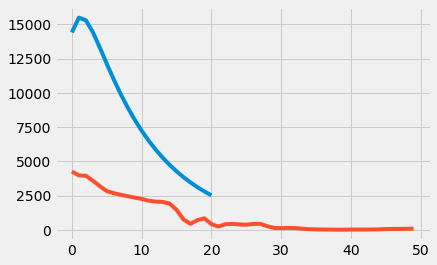

In [2610]:
plt.plot(results)
plt.plot(china_targets)

In [2611]:
# def train(params):
#     for 

In [2612]:
nS = 2
nA = 1
seed = 1078
net = Baseline(seed,nS,nA)

In [2613]:
X = np.arange(len(china_targets))
y = china_targets
degree = 1
line,coefs = return_polyfit(X,y,degree)

In [2614]:
print(coefs)

[2923.08294118  -77.32991597]


In [2615]:
print(poly.polyval(1, coefs))

2845.753025210082


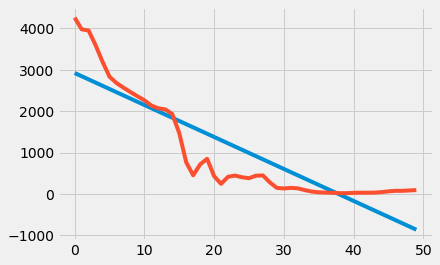

In [2616]:
plt.plot(line)
plt.plot(china_targets)